In [1]:
import pandas as pd
import glob as glob 
import matplotlib.pyplot as plt

from __future__ import division
from scipy import stats
%matplotlib inline

import numpy as np
import synapseclient

execfile('common_functions.py')

<a id='table.of.contents'></a>
## Table of Contents

1. <a href='#motivation'>Motivation to compare common variants observed in GENIE and TCGA</a><br>
2. <a href='#genie'>Common Variants in GENIE</a><br>
3. <a href='#tcga'>Common Variants in TCGA</a><br>
4. <a href='#comparison'>Comparison of GENIE to TCGA</a><br>
5. <a href='#conclusion'>Conclusion</a>

<a id='motivation'></a>
## Motivation to compare common variants observed in GENIE and TCGA
<a href='#table.of.contents'>Return to top</a><br>

A major concern with releasing patient genomic data is that germline variants may be released alongside the reported somatic mutations, opening a potential opportunity for sample reidentification. We explore how many common variants are observed in our dataset, in aggregate and by center, versus TCGA. A simple two-tailed t-test was implemented by the scipy statistics package to compare the distribution of common variants in GENIE to TCGA. 

Our filter to flag germline variants is defined as the following: 
- Remove variants which are observed in any cohort of ExAC more than 0.045% allele frequency 
- Unless observed in ClinGen

Both TCGA and GENIE mafs were annotated with VEP and VCF2MAF (https://github.com/mskcc/vcf2maf)

We hypothesize that GENIE contains significantly less common variants than TCGA when considered in aggregate and by center. This is likely heavily confounded by the considered sites of samples in TCGA versus GENIE as many GENIE centers utilized targeted panels tailored to their genomic coordinates of interest. 

(Something about this analysis is address that we are presenting potential germline sites than TCGA on average, we will present similar analyses to reduce the germline variants)

<a id='genie'></a>
## Common Variants in Genie
<a href='#table.of.contents'>Return to top</a><br>

In [106]:
df = pd.read_csv('/Users/brendan/Analysis/genie/Project Genie/data_mutations_extended.txt', sep = '\t',
                low_memory = False, comment = '#')

desired_classes = ['.', 'PASS', 'R8', 'SB', 'LOWGQ']
df_keep = df[df['FILTER'].isin(desired_classes)]
df_reject = df[~df['FILTER'].isin(desired_classes)]
print ''
print 'GENIE consists of', str(len(df['Tumor_Sample_Barcode'].unique())), 'tumor samples containing', str(len(df)), 'variants.'
print ''
print 'Our filter suggests that there are', str(len(df_reject)),'common variants within GENIE,'
print 'constituting a germline contamination rate of', str((10405)/(10405+90993)*100) + '%'


GENIE consists of 16220 tumor samples containing 101398 variants.

Our filter suggests that there are 10405 common variants within GENIE,
constituting a germline contamination rate of 10.2615436202%


In [107]:
plot_title = 'Common variants per sample, GENIE'
variants_per_sample = pd.DataFrame([], columns = ['sample', 'center', '# variants', '# common variants', '# uncommon variants'])
variants_per_sample.ix[:,'sample'] = df['Tumor_Sample_Barcode'].unique()
desired_classes = ['.', 'PASS', 'R8', 'SB', 'LOWGQ']

for sample_ in df['Tumor_Sample_Barcode'].unique():
    index_ = variants_per_sample[variants_per_sample['sample'] == sample_].index.tolist()[0]
    df_sample_ = df[df['Tumor_Sample_Barcode'] == sample_]
    
    variants_per_sample.ix[index_, 'center'] = df_sample_['Center'].unique().tolist()[0]
    variants_per_sample.ix[index_, '# variants'] = len(df_sample_)
    idx_common_variants = df_sample_['FILTER'].isin(desired_classes)
    variants_per_sample.ix[index_, '# common variants'] = len(df_sample_[~idx_common_variants])
    variants_per_sample.ix[index_, '# uncommon variants'] = len(df_sample_[idx_common_variants])
    
print 'For GENIE samples...'
print '...mean number of variants:', variants_per_sample.ix[:,'# variants'].mean()
print '...mean number of common variants:', variants_per_sample.ix[:,'# common variants'].mean()
print '...std dev of common variants:', variants_per_sample.ix[:,'# common variants'].std()
print '...max number of common variants:', variants_per_sample.ix[:, '# common variants'].max()
print ''

frac = len(variants_per_sample[variants_per_sample['# common variants'] <= variants_per_sample.ix[:,'# common variants'].mean()])
frac = frac/len(variants_per_sample)*100
print str(frac) + '% of samples have less than the mean number of common variants'

For GENIE samples...
...mean number of variants: 6.25141800247
...mean number of common variants: 0.641491985203
...std dev of common variants: 2.52331474949
...max number of common variants: 38

82.8545006165% of samples have less than the mean number of common variants


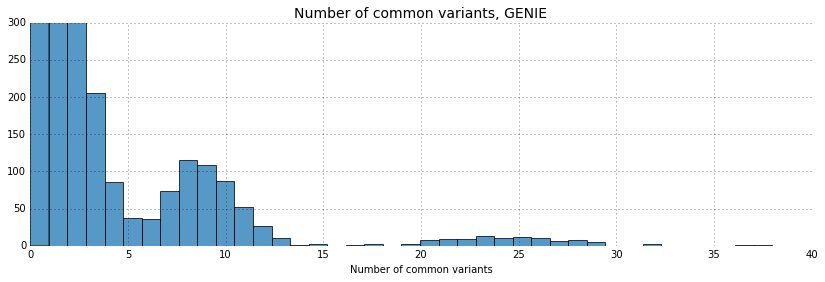

In [73]:
plt.figure(figsize=(14, 4))

ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
plt.tick_params(axis="both", which="both", bottom="off", top="off",
	labelbottom="on", left="off", right="off", labelleft="on")    

plt.hist(variants_per_sample['# common variants'], 40, facecolor = tableau20[0], alpha = 0.75) 
plt.axis([0, 40, 0, 300])

plt.title('Number of common variants, GENIE', fontsize = 14)
plt.xlabel('Number of common variants')

plt.grid(True)
plt.show()

<a id='tcga'></a>
## Common Variants in TCGA
<a href='#table.of.contents'>Return to top</a><br>

In [6]:
tcga_files = glob.glob('mafs/*')
cols = ['sample id', 'tumor type', '# variants', '# common variants', '# uncommon variants']
df_variants_tcga = pd.DataFrame([], columns = cols)
list_ = []

for file_ in tcga_files:
    tumortype = file_.split('/')[1].split('_')[1]
    print '--- Processing tumor type', str(tumortype) + ':', file_, '---'
    
    df_tumortype = pd.read_csv(file_, sep = '\t', low_memory = False)
    df_ = pd.DataFrame([], columns = cols)
    df_.ix[:,'sample id'] = df_tumortype['Tumor_Sample_Barcode'].unique()
    df_.ix[:,'tumor type'] = tumortype

    print len(df_.ix[:,'sample id'].unique()), 'samples found for this tumor type with', str(len(df_)), 'variants in total'
    print 'Extracting number of common variants per sample in this tumor type...'
    
    for sample_ in df_tumortype['Tumor_Sample_Barcode'].unique():
        index_ = df_[df_['sample id'] == sample_].index.tolist()[0]
        df_sample_ = df_tumortype[df_tumortype['Tumor_Sample_Barcode'] == sample_]
        
        df_.ix[index_, '# variants'] = len(df_sample_)
        idx_common_variants = df_sample_['FILTER'].str.contains('common_variant') # Change if we change the filter
        
        df_.ix[index_,'# common variants'] = len(df_sample_[idx_common_variants])
        df_.ix[index_,'# uncommon variants'] = len(df_sample_[~idx_common_variants])
        
        # Add piece to record progress along samples in a given tissue type
        
    print '... all samples have now processed for this tumor type (' + tumortype + ')'
    print ''
    print ''
    list_.append(df_)
    
df_variants_tcga = pd.concat(list_, ignore_index = True)

--- Processing tumor type acc: mafs/tcga_acc_071516.vep.maf ---
90 samples found for this tumor type with 90 variants in total
Extracting number of common variants per sample in this tumor type...
... all samples have now processed for this tumor type (acc)


--- Processing tumor type blca: mafs/tcga_blca_071516.vep.maf ---
392 samples found for this tumor type with 392 variants in total
Extracting number of common variants per sample in this tumor type...
... all samples have now processed for this tumor type (blca)


--- Processing tumor type brca: mafs/tcga_brca_071516.vep.maf ---
989 samples found for this tumor type with 989 variants in total
Extracting number of common variants per sample in this tumor type...
... all samples have now processed for this tumor type (brca)


--- Processing tumor type cesc: mafs/tcga_cesc_071516.vep.maf ---
191 samples found for this tumor type with 191 variants in total
Extracting number of common variants per sample in this tumor type...
... all s

In [7]:
print 'For TCGA samples...'
print '...mean number of variants:', df_variants_tcga.ix[:,'# variants'].mean()
print '...mean number of common variants:', df_variants_tcga.ix[:,'# common variants'].mean()
print '...std dev of common variants:', df_variants_tcga.ix[:,'# common variants'].std()
print '...max number of common variants:', df_variants_tcga.ix[:, '# common variants'].max()
print ''

frac = len(df_variants_tcga[df_variants_tcga['# common variants'] <= df_variants_tcga.ix[:,'# common variants'].mean()])
frac = frac/len(df_variants_tcga)*100
print str(frac) + '% of samples have less than the mean number of common variants'

For TCGA samples...
...mean number of variants: 207.309295133
...mean number of common variants: 12.3980139997
...std dev of common variants: 31.7498716812
...max number of common variants: 836

81.0027673775% of samples have less than the mean number of common variants


On the scale of the GENIE figure


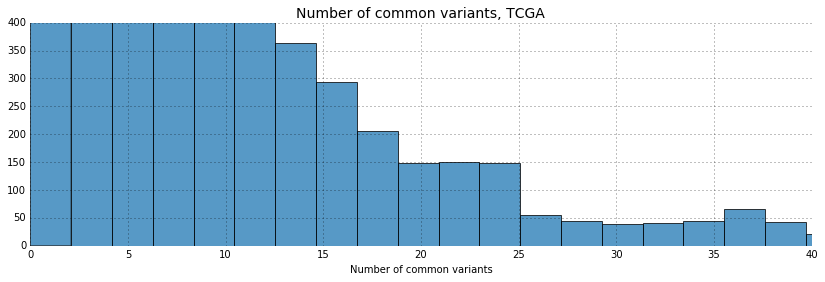

In [21]:
print 'On the scale of the GENIE figure'
plt.figure(figsize=(14, 4))

ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
plt.tick_params(axis="both", which="both", bottom="off", top="off",
	labelbottom="on", left="off", right="off", labelleft="on")    

plt.hist(df_variants_tcga['# common variants'], bins = 400, facecolor = tableau20[0], alpha = 0.75) 
plt.axis([0, 40, 0, 400])

plt.title('Number of common variants, TCGA', fontsize = 14)
plt.xlabel('Number of common variants')

plt.grid(True)
plt.show()

Number of common variants 0 -> 60


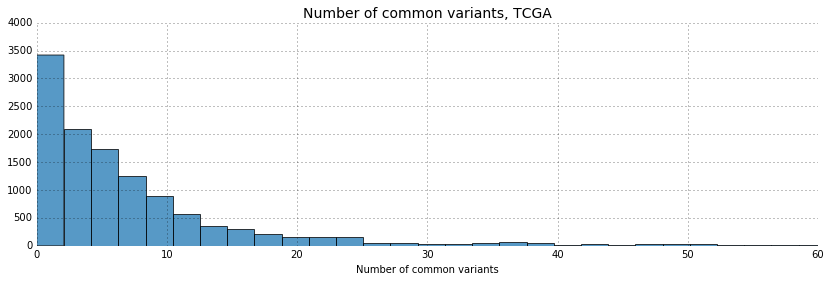

In [17]:
print 'Number of common variants 0 -> 60'
plt.figure(figsize=(14, 4))

ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
plt.tick_params(axis="both", which="both", bottom="off", top="off",
	labelbottom="on", left="off", right="off", labelleft="on")    

plt.hist(df_variants_tcga['# common variants'], bins = 400, facecolor = tableau20[0], alpha = 0.75) 
plt.axis([0, 40, 0, 4000])

plt.title('Number of common variants, TCGA', fontsize = 14)
plt.xlabel('Number of common variants')

plt.grid(True)
plt.show()

Number of common variants 60 -> 850


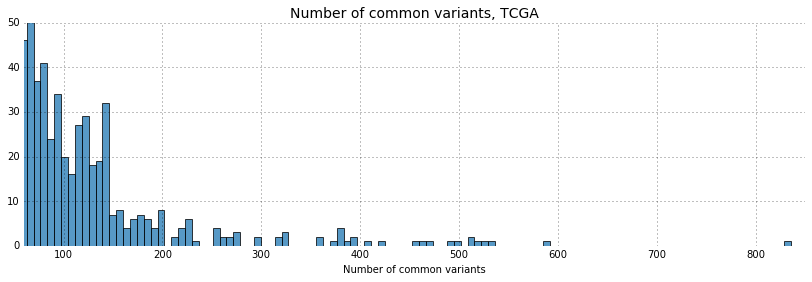

In [14]:
print 'Number of common variants 60 -> 850'
plt.figure(figsize=(14, 4))

ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
plt.tick_params(axis="both", which="both", bottom="off", top="off",
	labelbottom="on", left="off", right="off", labelleft="on")    

plt.hist(df_variants_tcga['# common variants'], bins = 120, facecolor = tableau20[0], alpha = 0.75) 
plt.axis([60, 850, 0, 50])

plt.title('Number of common variants, TCGA', fontsize = 14)
plt.xlabel('Number of common variants')

plt.grid(True)
plt.show()

<a id='comparison'></a>
## Comparison of GENIE to TCGA
<a href='#table.of.contents'>Return to top</a><br>

In [105]:
variants_genie = variants_per_sample
variants_tcga = df_variants_tcga

common_variants_genie = variants_genie['# common variants']
common_variants_tcga = variants_tcga['# common variants']

print 'We compare the # of common variants to TCGA by center'
print ''
centers = ['VICC', 'MSK', 'GRCC', 'JHH', 'UHN', 'NKI', 'DFCI', 'MDA']
for center_ in centers:
    print '----', center_, '----'
    df_center = variants_genie[variants_genie['center'] == center_]
    print 'mean:', df_center['# common variants'].mean()
    print 'std dev:', df_center['# common variants'].std()
    
    print 'Against TCGA:'
    statistic, pvalue = stats.ttest_ind(common_variants_tcga, df_center['# common variants'], equal_var = False)
    print '...test statistic:', statistic
    print '...p-value:', pvalue
    print ''
    
print ''
print 'What about the entire data sets? GENIE v TCGA' 
print ''
print 'GENIE mean:', common_variants_genie.mean(), '; GENIE std dev:', common_variants_genie.std() 
print 'TCGA mean:', common_variants_tcga.mean(), '; TCGA std dev:', common_variants_tcga.std()  
statistic, pvalue = stats.ttest_ind(common_variants_tcga, common_variants_genie, equal_var = False)
print '...test statistic:', statistic
print '...p-value:', pvalue
print ''

We compare the # of common variants to TCGA by center

---- VICC ----
mean: 4.23732251521
std dev: 6.99459301918
Against TCGA:
...test statistic: 22.4898624398
...p-value: 2.22386020283e-107

---- MSK ----
mean: 0.127748528956
std dev: 0.668734431644
Against TCGA:
...test statistic: 42.8187562041
...p-value: 0.0

---- GRCC ----
mean: 0.0620347394541
std dev: 0.251607426952
Against TCGA:
...test statistic: 43.0250682799
...p-value: 0.0

---- JHH ----
mean: 0.575559701493
std dev: 0.750897169074
Against TCGA:
...test statistic: 41.1418051281
...p-value: 0.0

---- UHN ----
mean: 0.157232704403
std dev: 0.714372162802
Against TCGA:
...test statistic: 42.6149822332
...p-value: 0.0

---- NKI ----
mean: 9.02370689655
std dev: 1.62375669276
Against TCGA:
...test statistic: 11.3921911448
...p-value: 6.43047156653e-30

---- DFCI ----
mean: 0.0760891797914
std dev: 0.292323647341
Against TCGA:
...test statistic: 43.0125888263
...p-value: 0.0

---- MDA ----
mean: 0.031175059952
std dev: 0.17389489

---- VICC ----
mean: 4.23732251521
std dev: 6.99459301918
Against TCGA:
...test statistic: 22.4898624398
...p-value: 2.22386020283e-107



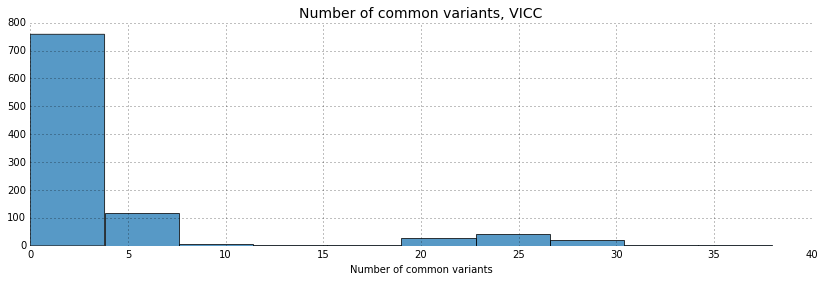

---- MSK ----
mean: 0.127748528956
std dev: 0.668734431644
Against TCGA:
...test statistic: 42.8187562041
...p-value: 0.0



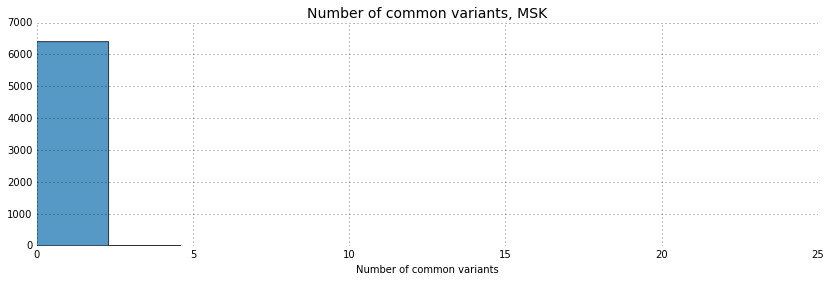

---- GRCC ----
mean: 0.0620347394541
std dev: 0.251607426952
Against TCGA:
...test statistic: 43.0250682799
...p-value: 0.0



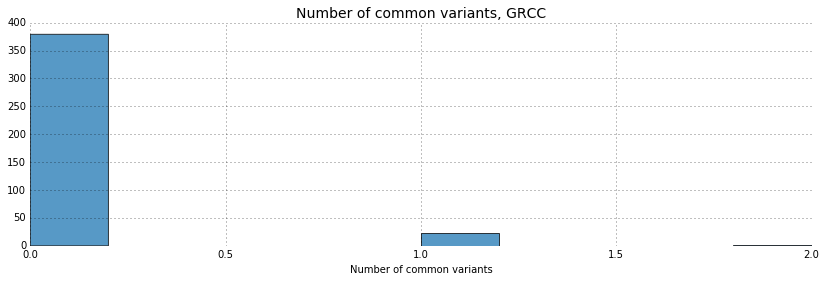

---- JHH ----
mean: 0.575559701493
std dev: 0.750897169074
Against TCGA:
...test statistic: 41.1418051281
...p-value: 0.0



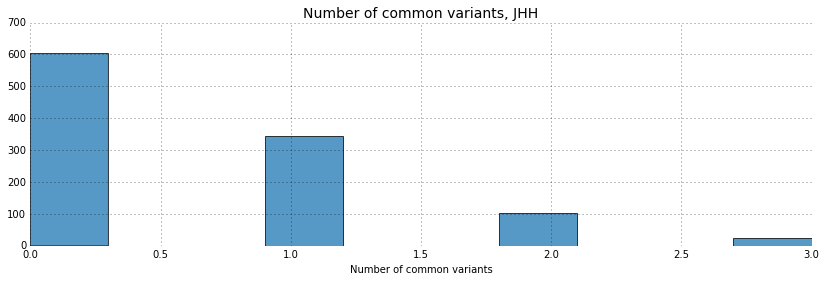

---- UHN ----
mean: 0.157232704403
std dev: 0.714372162802
Against TCGA:
...test statistic: 42.6149822332
...p-value: 0.0



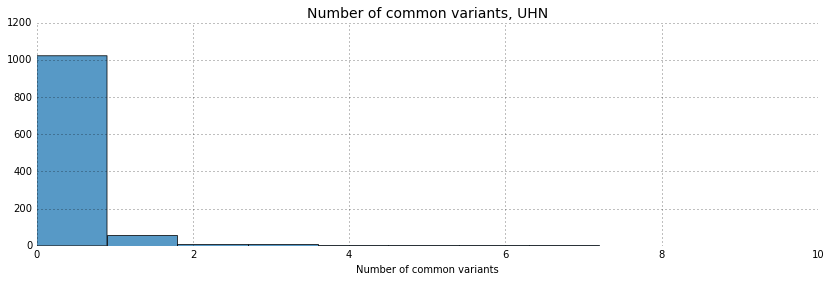

---- NKI ----
mean: 9.02370689655
std dev: 1.62375669276
Against TCGA:
...test statistic: 11.3921911448
...p-value: 6.43047156653e-30



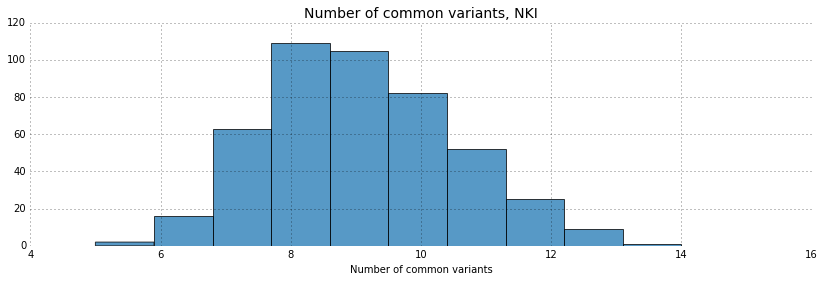

---- DFCI ----
mean: 0.0760891797914
std dev: 0.292323647341
Against TCGA:
...test statistic: 43.0125888263
...p-value: 0.0



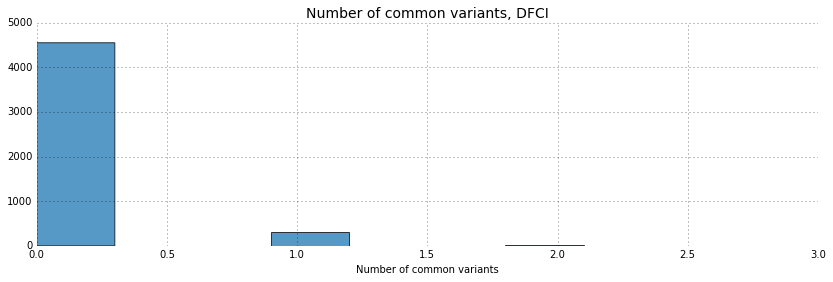

---- MDA ----
mean: 0.031175059952
std dev: 0.173894893263
Against TCGA:
...test statistic: 43.1644336918
...p-value: 0.0



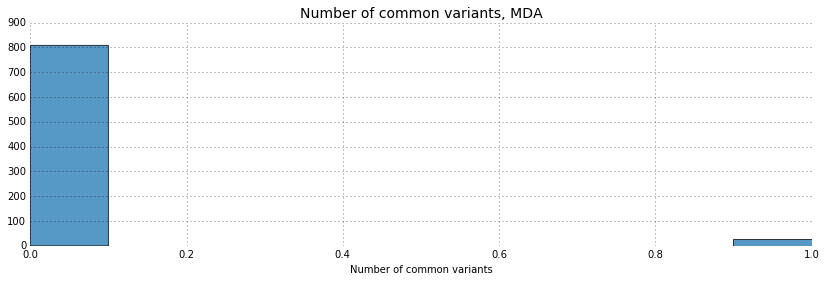

In [47]:
variants_genie = variants_per_sample
variants_tcga = df_variants_tcga

common_variants_genie = variants_genie['# common variants']
common_variants_tcga = variants_tcga['# common variants']

centers = ['VICC', 'MSK', 'GRCC', 'JHH', 'UHN', 'NKI', 'DFCI', 'MDA']
for center_ in centers:
    print '----', center_, '----'
    df_center = variants_genie[variants_genie['center'] == center_]
    print 'mean:', df_center['# common variants'].mean()
    print 'std dev:', df_center['# common variants'].std()
    
    print 'Against TCGA:'
    statistic, pvalue = stats.ttest_ind(common_variants_tcga, df_center['# common variants'], equal_var = False)
    print '...test statistic:', statistic
    print '...p-value:', pvalue
    print ''
    
    plt.figure(figsize=(14, 4))

    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
        labelbottom="on", left="off", right="off", labelleft="on")    

    plt.hist(df_center['# common variants'], facecolor = tableau20[0], alpha = 0.75) 
    #plt.axis([0, 40, 0, df_center['# common variants'].mean()*2])

    plt.title('Number of common variants, ' + center_, fontsize = 14)
    plt.xlabel('Number of common variants')

    plt.grid(True)
    plt.show()

How many samples in GENIE contain more common variants than the mean # common variants in TCGA samples?

To reiterate, TCGA samples on average have 12.3980139997 common variants
114 / 16220 (0.702836004932%) samples in GENIE have more common variants than this


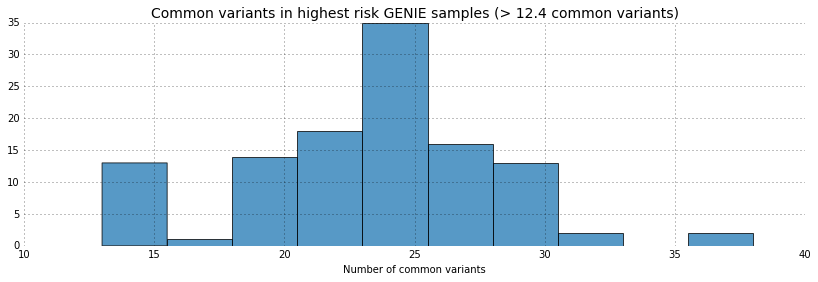

In [102]:
print 'How many samples in GENIE contain more common variants than the mean # common variants in TCGA samples?'
print ''
print 'To reiterate, TCGA samples on average have', str(common_variants_tcga.mean()), 'common variants'

top_genie = variants_genie[variants_genie['# common variants'] > common_variants_tcga.mean()]
print len(top_genie['sample'].unique()), '/', str(len(variants_genie['sample'].unique())), \
    '(' + str(len(top_genie['sample'].unique()) / len(variants_genie['sample'].unique()) *100) + '%)', \
    'samples in GENIE have more common variants than this'

plt.figure(figsize=(14, 4))

ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
plt.tick_params(axis="both", which="both", bottom="off", top="off",
	labelbottom="on", left="off", right="off", labelleft="on")    

plt.hist(top_genie['# common variants'], facecolor = tableau20[0], alpha = 0.75) 

plt.title('Common variants in highest risk GENIE samples (> 12.4 common variants)', fontsize = 14)
plt.xlabel('Number of common variants')

plt.grid(True)
plt.show()

<a id='conclusion'></a>
## Conclusion
<a href='#table.of.contents'>Return to top</a><br>
We have shown that GENIE contains many less common variants than TCGA, an already publicly available dataset, and believe that the GENIE dataset is at low risk for potential reidentification for any sample.